In [3]:
!pip install -q git+https://github.com/huggingface/transformers.git datasets
!pip install -q evaluate

## Lib_HSI dataset

## Load dataset

The section is for semantic segmentation done for rgb images using a DinoV2 backbone and linear head.

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.2.1) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Generating validation split: 100%|██████████| 2135/2135 [00:00<00:00, 9755.65 examples/s]


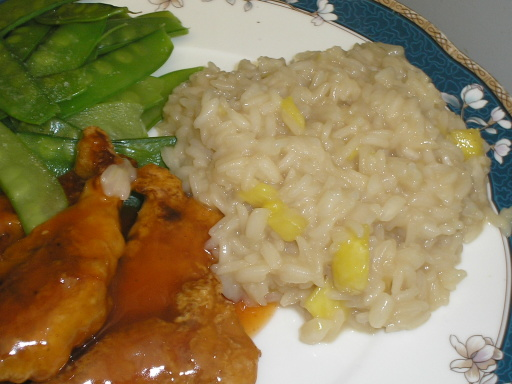

In [ ]:
from datasets import load_dataset

dataset = load_dataset("EduardoPacheco/FoodSeg103")

example = dataset["train"][0]
image = example["image"]

image

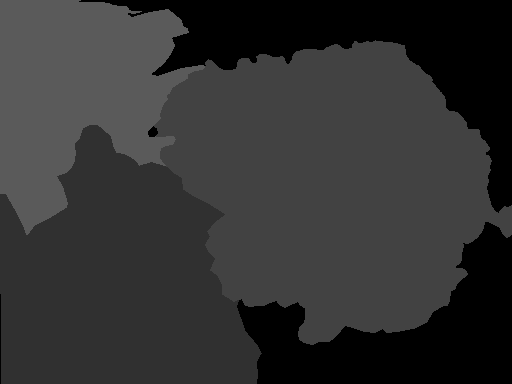

In [ ]:
segmentation_map = example["label"]
segmentation_map

In [ ]:
import numpy as np

segmentation_map = np.array(segmentation_map)

id2label = {
    0: "background",
    1: "candy",
    2: "egg tart",
    3: "french fries",
    4: "chocolate",
    5: "biscuit",
    6: "popcorn",
    7: "pudding",
    8: "ice cream",
    9: "cheese butter",
    10: "cake",
    11: "wine",
    12: "milkshake",
    13: "coffee",
    14: "juice",
    15: "milk",
    16: "tea",
    17: "almond",
    18: "red beans",
    19: "cashew",
    20: "dried cranberries",
    21: "soy",
    22: "walnut",
    23: "peanut",
    24: "egg",
    25: "apple",
    26: "date",
    27: "apricot",
    28: "avocado",
    29: "banana",
    30: "strawberry",
    31: "cherry",
    32: "blueberry",
    33: "raspberry",
    34: "mango",
    35: "olives",
    36: "peach",
    37: "lemon",
    38: "pear",
    39: "fig",
    40: "pineapple",
    41: "grape",
    42: "kiwi",
    43: "melon",
    44: "orange",
    45: "watermelon",
    46: "steak",
    47: "pork",
    48: "chicken duck",
    49: "sausage",
    50: "fried meat",
    51: "lamb",
    52: "sauce",
    53: "crab",
    54: "fish",
    55: "shellfish",
    56: "shrimp",
    57: "soup",
    58: "bread",
    59: "corn",
    60: "hamburg",
    61: "pizza",
    62: "hanamaki baozi",
    63: "wonton dumplings",
    64: "pasta",
    65: "noodles",
    66: "rice",
    67: "pie",
    68: "tofu",
    69: "eggplant",
    70: "potato",
    71: "garlic",
    72: "cauliflower",
    73: "tomato",
    74: "kelp",
    75: "seaweed",
    76: "spring onion",
    77: "rape",
    78: "ginger",
    79: "okra",
    80: "lettuce",
    81: "pumpkin",
    82: "cucumber",
    83: "white radish",
    84: "carrot",
    85: "asparagus",
    86: "bamboo shoots",
    87: "broccoli",
    88: "celery stick",
    89: "cilantro mint",
    90: "snow peas",
    91: "cabbage",
    92: "bean sprouts",
    93: "onion",
    94: "pepper",
    95: "green beans",
    96: "French beans",
    97: "king oyster mushroom",
    98: "shiitake",
    99: "enoki mushroom",
    100: "oyster mushroom",
    101: "white button mushroom",
    102: "salad",
    103: "other ingredients"
}

Visualize the segmentation map on top of the image.

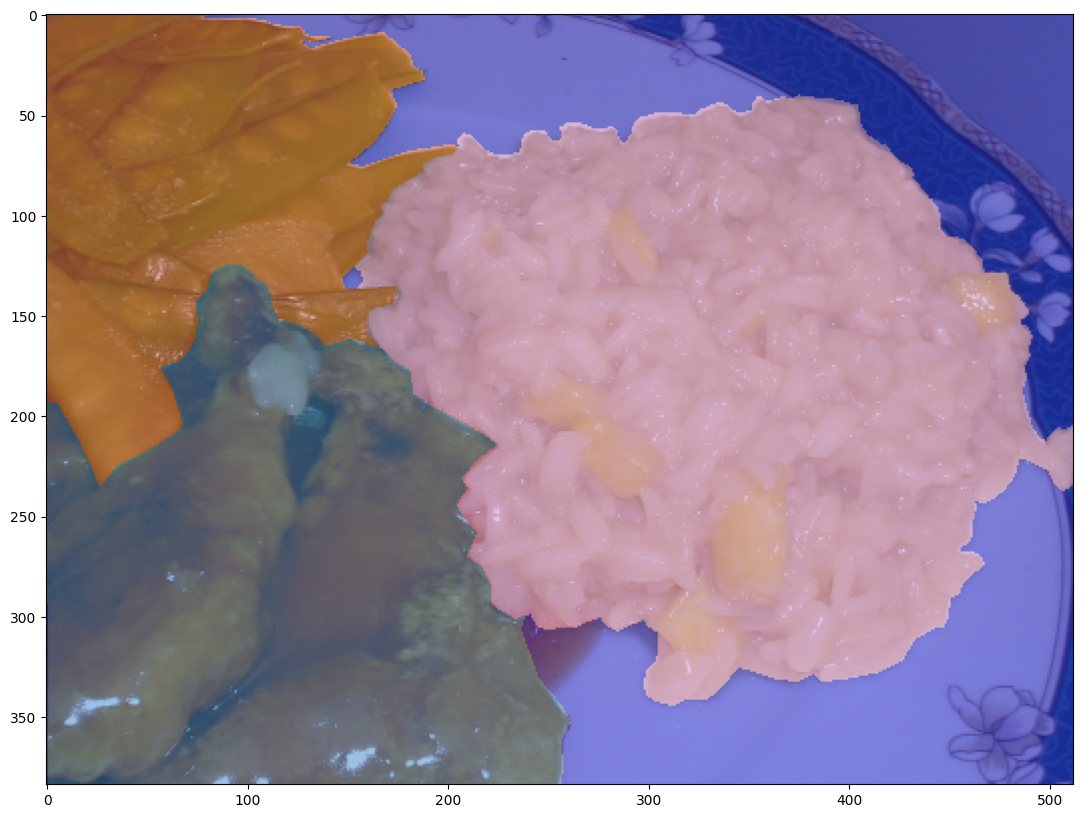

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# map every class to a random color
id2color = {k: list(np.random.choice(range(256), size=3)) for k,v in id2label.items()}

def visualize_map(image, segmentation_map):
    color_seg = np.zeros((segmentation_map.shape[0], segmentation_map.shape[1], 3), dtype=np.uint8) # height, width, 3
    for label, color in id2color.items():
        color_seg[segmentation_map == label, :] = color

    # Show image + mask
    img = np.array(image) * 0.5 + color_seg * 0.5
    img = img.astype(np.uint8)

    plt.figure(figsize=(15, 10))
    plt.imshow(img)
    plt.show()

visualize_map(image, segmentation_map)

## Create PyTorch dataset

We create a regular PyTorch dataset, which prepares the examples for the model. We augment the training images by random resizing and cropping them to a fixed resolution (448x448), and normalize the color channels. This way, all our training images will have the same fixed resolution. Here we use the [Albumentations](https://albumentations.ai/) library for that purpose, but note that one can also use other libraries like Torchvision or Kornia.

 Note that the model will expect `pixel_values` of shape (batch_size, num_channels, height, width) as input. As Albumentations works on NumPy arrays (which uses a channels-last format), we make sure that the channels are first. The `labels` which the model also expects are of shape (batch_size, height, width) and indicate the ground truth label per pixel, for every example in the batch.

In [ ]:
from torch.utils.data import Dataset
import torch

class SegmentationDataset(Dataset):
  def __init__(self, dataset, transform):
    self.dataset = dataset
    self.transform = transform

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    original_image = np.array(item["image"])
    original_segmentation_map = np.array(item["label"])

    transformed = self.transform(image=original_image, mask=original_segmentation_map)
    image, target = torch.tensor(transformed['image']), torch.LongTensor(transformed['mask'])

    # convert to C, H, W
    image = image.permute(2,0,1)

    return image, target, original_image, original_segmentation_map

In [ ]:
!pip install albumentations
import albumentations as A

ADE_MEAN = np.array([123.675, 116.280, 103.530]) / 255
ADE_STD = np.array([58.395, 57.120, 57.375]) / 255

train_transform = A.Compose([
    # hadded an issue with an image being too small to crop, PadIfNeeded didn't help...
    # if anyone knows why this is happening I'm happy to read why
    # A.PadIfNeeded(min_height=448, min_width=448),
    # A.RandomResizedCrop(height=448, width=448),
    A.Resize(width=448, height=448),
    A.HorizontalFlip(p=0.5),
    A.Normalize(mean=ADE_MEAN, std=ADE_STD),
])

val_transform = A.Compose([
    A.Resize(width=448, height=448),
    A.Normalize(mean=ADE_MEAN, std=ADE_STD),

])

train_dataset = SegmentationDataset(dataset["train"], transform=train_transform)
val_dataset = SegmentationDataset(dataset["validation"], transform=val_transform)

pixel_values, target, original_image, original_segmentation_map = train_dataset[3]

In [ ]:
from PIL import Image

Image.fromarray(original_image)

[id2label[id] for id in np.unique(original_segmentation_map).tolist()]

['background', 'chicken duck', 'carrot', 'asparagus', 'broccoli']

## Create PyTorch dataloaders

Next, we create PyTorch dataloaders, which allow us to get batches of data (as neural networks are trained on batches using stochastic gradient descent or SGD). We just stack the various images and labels along a new batch dimension.

In [ ]:
from torch.utils.data import DataLoader

def collate_fn(inputs):
    batch = dict()
    batch["pixel_values"] = torch.stack([i[0] for i in inputs], dim=0)
    batch["labels"] = torch.stack([i[1] for i in inputs], dim=0)
    batch["original_images"] = [i[2] for i in inputs]
    batch["original_segmentation_maps"] = [i[3] for i in inputs]

    return batch

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn)

batch = next(iter(train_dataloader))
for k,v in batch.items():
  if isinstance(v,torch.Tensor):
    print(k,v.shape)

pixel_values torch.Size([2, 3, 448, 448])
labels torch.Size([2, 448, 448])


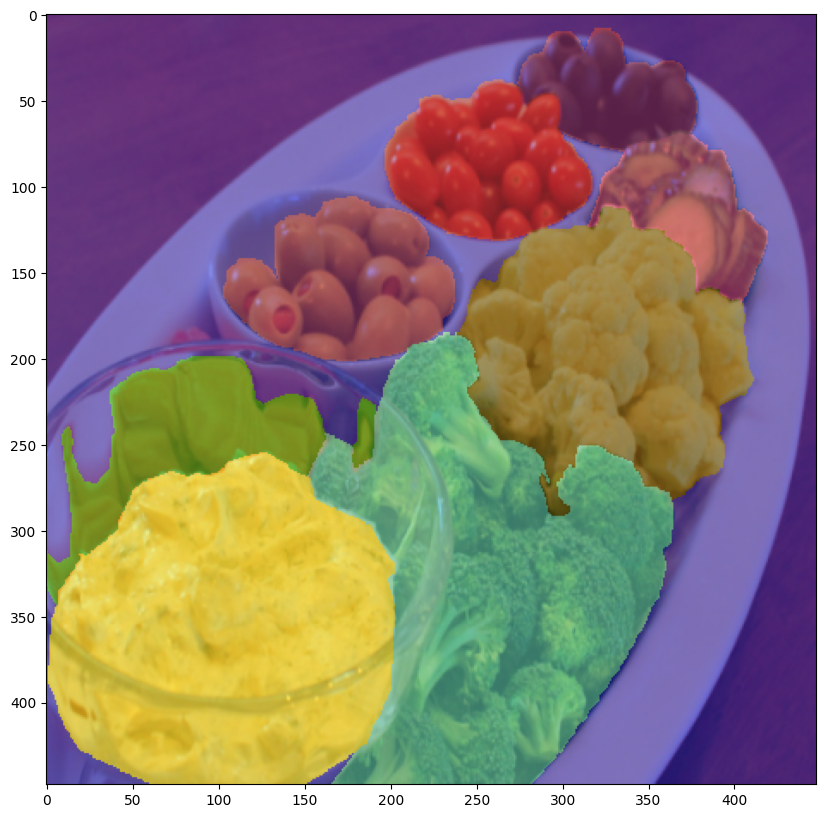

In [ ]:
from PIL import Image

unnormalized_image = (batch["pixel_values"][0].numpy() * np.array(ADE_STD)[:, None, None]) + np.array(ADE_MEAN)[:, None, None]
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
unnormalized_image = Image.fromarray(unnormalized_image)
unnormalized_image

[id2label[id] for id in torch.unique(batch["labels"][0]).tolist()]

visualize_map(unnormalized_image, batch["labels"][0].numpy())

## Define model

Next, we define the model, which consists of DINOv2 as backbone + a linear classifier on top. DINOv2 is a regular vision transformer, hence it outputs "patch embeddings", meaning an embedding vector for each image patch. Since we use an image resolution of 448 pixels, and we use a DINOv2 model that has a patch resolution of 14 as seen [here](https://huggingface.co/facebook/dinov2-base/blob/main/config.json#L19), we get (448/14)**2 = 1024 patches out. So the model outputs a tensor of shape (batch_size, number of patches, hidden_size) = (batch_size, 1024, 768) for a batch of images (the model has a hidden size - also called embedding dimension - of 768 as seen [here](https://huggingface.co/facebook/dinov2-base/blob/main/config.json#L9)).

Next, we reshape this tensor to become (batch_size, 32, 32, 768), after which we apply the linear layer (below implemented as a Conv2D layer - which is equivalent to a linear transformation when you employ a kernel size of 1x1). This conv2D layer converts the patch embeddings into a logits tensor of shape (batch_size, num_labels, height, width) - which is what we need for semantic segmentation. This tensor contains scores as predicted by the model for all of the classes, for each pixel, for every example in the batch.

In [ ]:
import torch
from transformers import Dinov2Model, Dinov2PreTrainedModel
from transformers.modeling_outputs import SemanticSegmenterOutput

class LinearClassifier(torch.nn.Module):
    def __init__(self, in_channels, tokenW=32, tokenH=32, num_labels=1):
        super(LinearClassifier, self).__init__()

        self.in_channels = in_channels
        self.width = tokenW
        self.height = tokenH
        self.classifier = torch.nn.Conv2d(in_channels, num_labels, (1,1))

    def forward(self, embeddings):
        embeddings = embeddings.reshape(-1, self.height, self.width, self.in_channels)
        embeddings = embeddings.permute(0,3,1,2)

        return self.classifier(embeddings)


class Dinov2ForSemanticSegmentation(Dinov2PreTrainedModel):
  def __init__(self, config):
    super().__init__(config)

    self.dinov2 = Dinov2Model(config)
    self.classifier = LinearClassifier(config.hidden_size, 32, 32, config.num_labels)

  def forward(self, pixel_values, output_hidden_states=False, output_attentions=False, labels=None):
    # use frozen features
    outputs = self.dinov2(pixel_values,
                            output_hidden_states=output_hidden_states,
                            output_attentions=output_attentions)
    # get the patch embeddings - so we exclude the CLS token
    patch_embeddings = outputs.last_hidden_state[:,1:,:]

    # convert to logits and upsample to the size of the pixel values
    logits = self.classifier(patch_embeddings)
    logits = torch.nn.functional.interpolate(logits, size=pixel_values.shape[2:], mode="bilinear", align_corners=False)

    loss = None
    if labels is not None:
      # important: we're going to use 0 here as ignore index instead of the default -100
      # as we don't want the model to learn to predict background
      loss_fct = torch.nn.CrossEntropyLoss(ignore_index=0)
      loss = loss_fct(logits.squeeze(), labels.squeeze())

    return SemanticSegmenterOutput(
        loss=loss,
        logits=logits,
        hidden_states=outputs.hidden_states,
        attentions=outputs.attentions,
    )


In [ ]:
model = Dinov2ForSemanticSegmentation.from_pretrained("facebook/dinov2-base", id2label=id2label, num_labels=len(id2label))

Some weights of Dinov2ForSemanticSegmentation were not initialized from the model checkpoint at facebook/dinov2-base and are newly initialized: ['classifier.classifier.bias', 'classifier.classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Important: we don't want to train the DINOv2 backbone, only the linear classification head. Hence we don't want to track any gradients for the backbone parameters. This will greatly save us in terms of memory used:

In [ ]:
for name, param in model.named_parameters():
  if name.startswith("dinov2"):
    param.requires_grad = False

In [ ]:
outputs = model(pixel_values=batch["pixel_values"], labels=batch["labels"])
print(outputs.logits.shape)
print(outputs.loss)

torch.Size([2, 104, 448, 448])
tensor(5.3056, grad_fn=<NllLoss2DBackward0>)


In [ ]:
import evaluate

metric = evaluate.load("mean_iou")

from torch.optim import AdamW
from tqdm.auto import tqdm

# training hyperparameters
# NOTE: I've just put some random ones here, not optimized at all
# feel free to experiment, see also DINOv2 paper
learning_rate = 5e-5
epochs = 10

optimizer = AdamW(model.parameters(), lr=learning_rate)

# put model on GPU (set runtime to GPU in Google Colab)
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# put model in training mode
model.train()

for epoch in range(epochs):
  print("Epoch:", epoch)
  for idx, batch in enumerate(tqdm(train_dataloader)):
      pixel_values = batch["pixel_values"].to(device)
      labels = batch["labels"].to(device)

      # forward pass
      outputs = model(pixel_values, labels=labels)
      loss = outputs.loss

      loss.backward()
      optimizer.step()

      # zero the parameter gradients
      optimizer.zero_grad()

      # evaluate
      with torch.no_grad():
        predicted = outputs.logits.argmax(dim=1)

        # note that the metric expects predictions + labels as numpy arrays
        metric.add_batch(predictions=predicted.detach().cpu().numpy(), references=labels.detach().cpu().numpy())

      # let's print loss and metrics every 100 batches
      if idx % 100 == 0:
        metrics = metric.compute(num_labels=len(id2label),
                                ignore_index=0,
                                reduce_labels=False,
        )

        print("Loss:", loss.item())
        print("Mean_iou:", metrics["mean_iou"])
        print("Mean accuracy:", metrics["mean_accuracy"])

Epoch: 0


  0%|          | 0/2492 [00:00<?, ?it/s]/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
  0%|          | 1/2492 [00:03<2:40:26,  3.86s/it]

Loss: 5.503063201904297
Mean_iou: 1.0624734381640459e-05
Mean accuracy: 9.140350075407889e-05


  1%|          | 20/2492 [01:15<2:36:07,  3.79s/it]


KeyboardInterrupt: 

Now test.

torch.Size([1, 3, 448, 448])


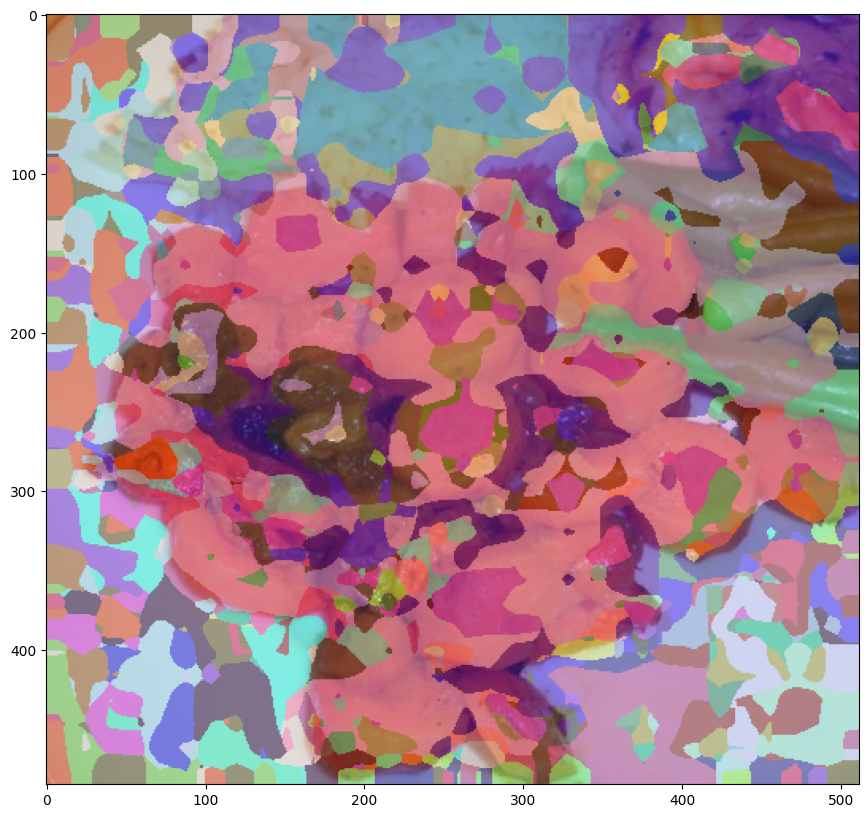

In [ ]:
from PIL import Image

test_image = dataset["validation"][0]["image"]
test_image

pixel_values = val_transform(image=np.array(test_image))["image"]
pixel_values = torch.tensor(pixel_values)
pixel_values = pixel_values.permute(2,0,1).unsqueeze(0) # convert to (batch_size, num_channels, height, width)
print(pixel_values.shape)

with torch.no_grad():
  outputs = model(pixel_values.to(device))

upsampled_logits = torch.nn.functional.interpolate(outputs.logits,
                                                   size=test_image.size[::-1],
                                                   mode="bilinear", align_corners=False)
predicted_map = upsampled_logits.argmax(dim=1)

visualize_map(test_image, predicted_map.squeeze().cpu())

